In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from scipy.interpolate import RegularGridInterpolator

In [2]:
# Function to plot FOV box
def plotFOVbox(ax, box, formatStr):
    
    xf,yf,zf = np.meshgrid(box[:,0],box[:,1],box[:,2], indexing='ij')
    ptsBox = np.transpose(np.array([xf.ravel(),yf.ravel(),zf.ravel()]))

    ax.plot( ptsBox[[0,1,3,2,0],0], ptsBox[[0,1,3,2,0],1], ptsBox[[0,1,3,2,0],2], formatStr)
    ax.plot( ptsBox[[2,3,7,6,2],0], ptsBox[[2,3,7,6,2],1], ptsBox[[2,3,7,6,2],2], formatStr)
    ax.plot( ptsBox[[0,1,5,4,0],0], ptsBox[[0,1,5,4,0],1], ptsBox[[0,1,5,4,0],2], formatStr)
    ax.plot( ptsBox[[4,5,7,6,4],0], ptsBox[[4,5,7,6,4],1], ptsBox[[4,5,7,6,4],2], formatStr)

# Function to marching cube meshes
def plotMesh(ax, mesh, ax_x, ax_y, ax_z, azim, elev):
    
    ax.add_collection3d(mesh)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim(ax_x[0], ax_x[1])  
    ax.set_ylim(ax_y[0], ax_y[1])  
    ax.set_zlim(ax_z[0], ax_z[1]) 
    ax.set_aspect('equal')
    ax.azim = azim
    ax.elev = elev

In [3]:
# Load both the image and segmentation

## -- The dataset folder -- ##

dataFolder = 'data/IE/scrambled/'
movingFile = 'image2.nii'
movingSegmentFile = 'label2.nii'

## ------------------------ ##

# Load and define the relevant header information for quick reference
nii_mov = nib.load(dataFolder + movingFile)
niiBin_mov = nib.load(dataFolder + movingSegmentFile)

affine = nii_mov.affine
imgDim = nii_mov.header['dim'][1:4]
imgSpacing = nii_mov.header['pixdim'][1:4]

print('Image dimensions and voxel size')
print(imgDim)
print(imgSpacing)

print('\nThe affine matrix of the original volume')
print(affine)

Image dimensions and voxel size
[292 229 166]
[0.075 0.075 0.075]

The affine matrix of the original volume
[[ 0.075  0.     0.    -0.   ]
 [ 0.     0.075  0.    -0.   ]
 [ 0.     0.     0.075  0.   ]
 [ 0.     0.     0.     1.   ]]


FOV bounds in world coordinates
[[ 0.          0.          0.        ]
 [21.82500087 17.10000068 12.37500049]]


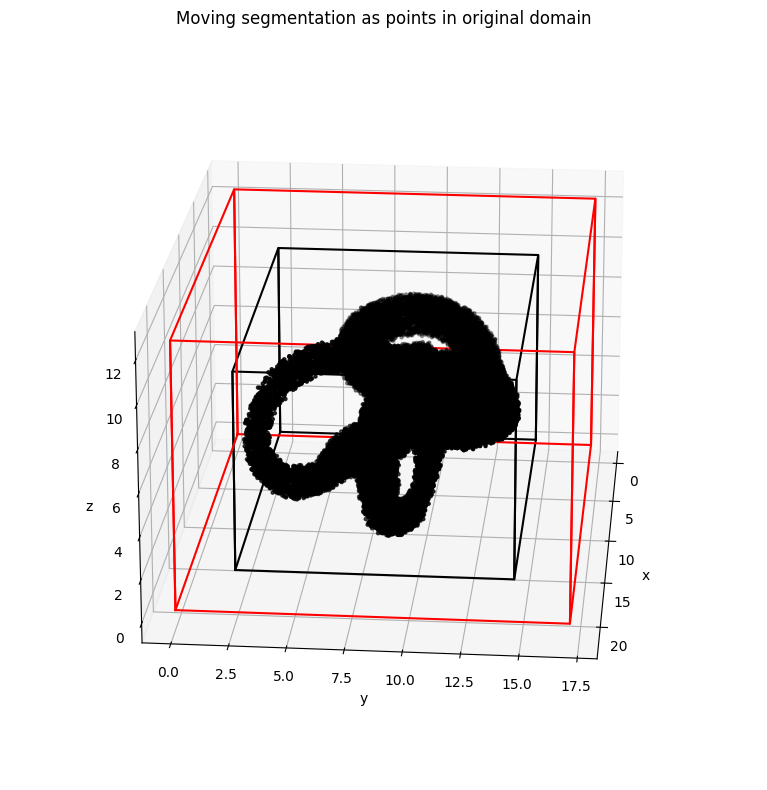

In [4]:
# Bounds of FOV
fov_pts = np.array([[0,0,0], [imgDim[0]-1, imgDim[1]-1, imgDim[2]-1]])
fov_pts = fov_pts @ affine[0:3, 0:3] # Apply the affine transformation (rotation and scaling)
fov_pts = fov_pts + affine[0:3, 3] # Apply the affine transformation (translation)
print('FOV bounds in world coordinates')
print(fov_pts)

# Get the foreground as point coordinates
pi, pj, ps = np.where(niiBin_mov.get_fdata() > 0)

# Stack into a array of n X 3 and convert to world coordinates
points = np.vstack((pi, pj, ps)).T
points = points @ affine[0:3, 0:3] # Apply the affine transformation (rotation and scaling)
points = points + affine[0:3, 3] # Apply the affine transformation (translation)

# Bounding box of points
x_min, y_min, z_min = np.min(points, axis=0)
x_max, y_max, z_max = np.max(points, axis=0)
box = np.array([[x_min, y_min, z_min], [x_max, y_max, z_max]])

# Plot a subset of the points

## --- Choose a subset of points and view point of display --- ##

subset = 10
viewPoint = [5, 20] # [azimuth, elevation angle]

## ----------------------------------------------------------- ##

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(points[::subset,0], points[::subset,1], points[::subset,2], c='k', marker='.')
plotFOVbox(ax, box, 'k')
plotFOVbox(ax, fov_pts, 'r')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_aspect('equal')
ax.azim = viewPoint[0]
ax.elev = viewPoint[1]
ax.set_title('Moving segmentation as points in original domain')
plt.tight_layout()
plt.show()

# Perform PCA and rotate the point cloud

In [5]:
## Principal Component Analysis (PCA) of the point cloud
points_mu = np.mean(points, axis = 0) # Center the point cloud
cov = np.cov(np.transpose(points)) # Covariance matrix 
rotation_matrix = np.linalg.svd(cov)[0]
print(points_mu)

## SVD ##
U, S, Vt = np.linalg.svd(cov)

# Apply transform to rotated pointcloud
# - translate (remove mean), and then rotate
points_rot = (points - points_mu) @ rotation_matrix

print(points_rot.shape)

[10.43172733  9.23160247  6.08980578]
(498148, 3)


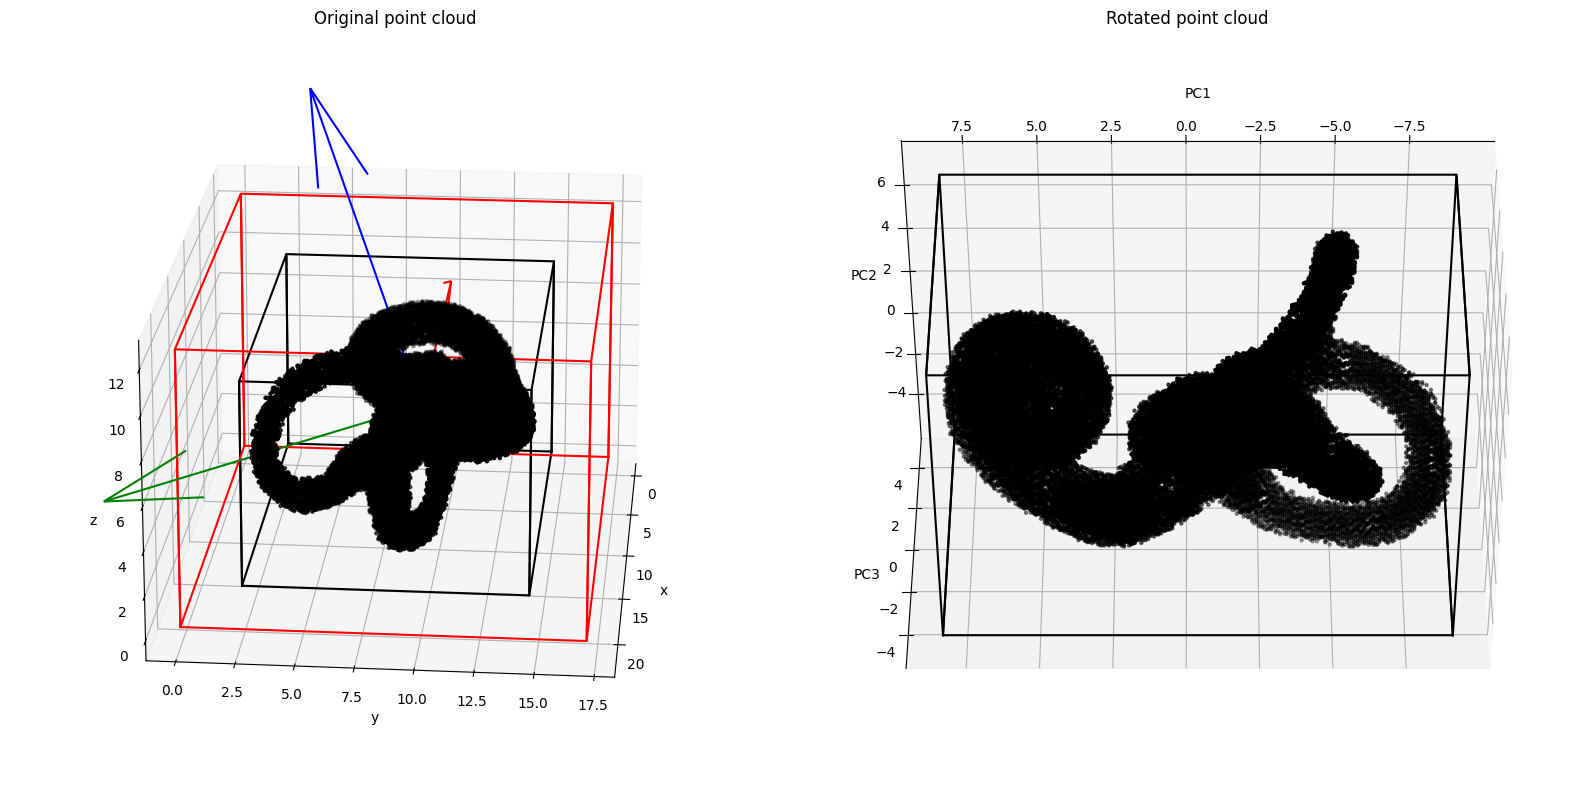

In [6]:
# Display the result
# -- Add principal axes to original point cloud plot
# -- Plot rotated point cloud

# Bounding box
x_min, y_min, z_min = np.min(points_rot, axis=0)
x_max, y_max, z_max = np.max(points_rot, axis=0)
box_rot = np.array([[x_min, y_min, z_min], [x_max, y_max, z_max]])

# Plot the rotated pointcloud
fig = plt.figure(figsize=(16, 8))

# display the original point cloud with the principal axes
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(points[::subset,0], points[::subset,1], points[::subset,2], c='k', marker='.')
plotFOVbox(ax, box, 'k')
plotFOVbox(ax, fov_pts, 'r')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_aspect('equal')
ax.azim = viewPoint[0]
ax.elev = viewPoint[1]
ax.set_title('Original point cloud')

## --- Add the principal axes to the plot using quiver() --- ##
eigenvectors = U
ax.quiver(points_mu[0], points_mu[1], points_mu[2], eigenvectors[0,0], eigenvectors[1,0], eigenvectors[2,0], color='r', length=20, normalize=True)
ax.quiver(points_mu[0], points_mu[1], points_mu[2], eigenvectors[0,1], eigenvectors[1,1], eigenvectors[2,1], color='g', length=15, normalize=True)
ax.quiver(points_mu[0], points_mu[1], points_mu[2], eigenvectors[0,2], eigenvectors[1,2], eigenvectors[2,2], color='b', length=15, normalize=True)
    

# ---------------------------------------------------------- ##

# Display the rotated point cloud 
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(points_rot[::subset,0], points_rot[::subset,1], points_rot[::subset,2], c='k', marker='.')
plotFOVbox(ax, box_rot, 'k')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_aspect('equal')
ax.azim = 90
ax.elev = -45
ax.set_title('Rotated point cloud')
plt.tight_layout()

# Resample the volume in a PCA aligned domain

In [7]:
# Set up grid interpolator for the moving image

# --- Choose inter-/extra-polation --- #

intMethod = 'linear' #Options: "linear", "nearest", "slinear", "cubic", "quintic" and "pchip" 
expVal = 0  #Value for extrapolation (i.e. values outside volume domain)

# ------------------------------------ #

# Set-up interpolators for moving image
x = np.arange(start=0, stop=imgDim[0], step=1) * imgSpacing[0] + affine[0,3]
y = np.arange(start=0, stop=imgDim[1], step=1) * imgSpacing[1] + affine[1,3]
z = np.arange(start=0, stop=imgDim[2], step=1) * imgSpacing[2] + affine[2,3]
F_moving = RegularGridInterpolator((x, y, z), nii_mov.get_fdata().astype('float16'), method=intMethod, bounds_error=False, fill_value=expVal)

[[-19.07972773 -15.34126441 -14.83661999]
 [ 18.28153335  17.08194928  14.7615629 ]]
New volume dimensions
(39, 34, 31)


Text(0.5, 0.92, 'New sample points (PCA domain)')

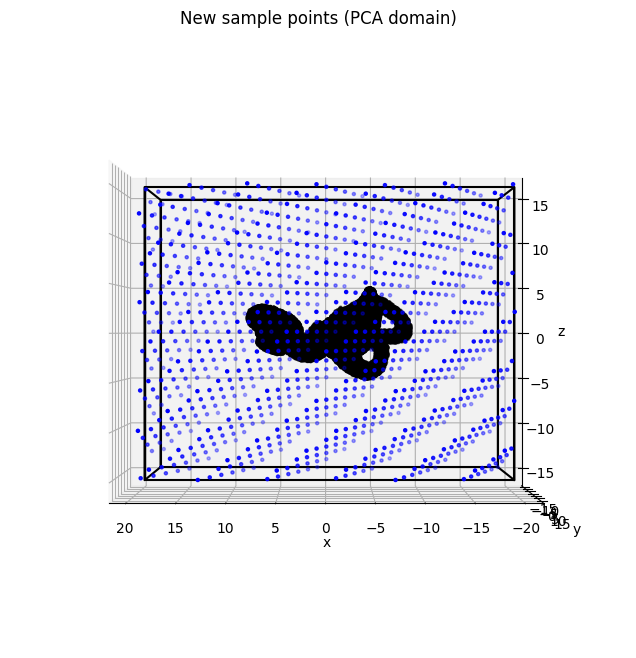

In [9]:
# Set-up new resampling domain
## --- Choose the new grid --- ##
xMin, yMin, zMin = np.min(points_rot, axis=0) - 10  # Adding some padding
xMax, yMax, zMax = np.max(points_rot, axis=0) + 10  # Adding some padding

spacing =  1# The new voxel size (assuming isotropic)

boxPad = np.array([[xMin, yMin, zMin], [xMax, yMax, zMax]])   
print(boxPad)

## --------------------------- ##

# Define the query grid (physical space)
vX = np.arange(xMin, xMax+spacing, spacing) 
vY = np.arange(yMin, yMax+spacing, spacing) 
vZ = np.arange(zMin, zMax+spacing, spacing) 
qX,qY,qZ = np.meshgrid(vX,vY,vZ, indexing='ij')
ptsQ = np.transpose(np.array([qX.ravel(),qY.ravel(),qZ.ravel()])) # Now stored as [N x 3] pointset

print('New volume dimensions')
print(qX.shape)

# Plot the query grid
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1, projection='3d')
plotFOVbox(ax, boxPad, 'k')
ax.scatter(ptsQ[::subset*4,0], ptsQ[::subset*4,1], ptsQ[::subset*4,2], c='b', marker='.')
ax.scatter(points_rot[::subset,0], points_rot[::subset,1], points_rot[::subset,2], c='k', marker='.')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_aspect('equal')
ax.azim = 90
ax.elev = 0
ax.set_title('New sample points (PCA domain)')

Text(0.5, 0.92, 'FOV and transformed sample points (moving domain)')

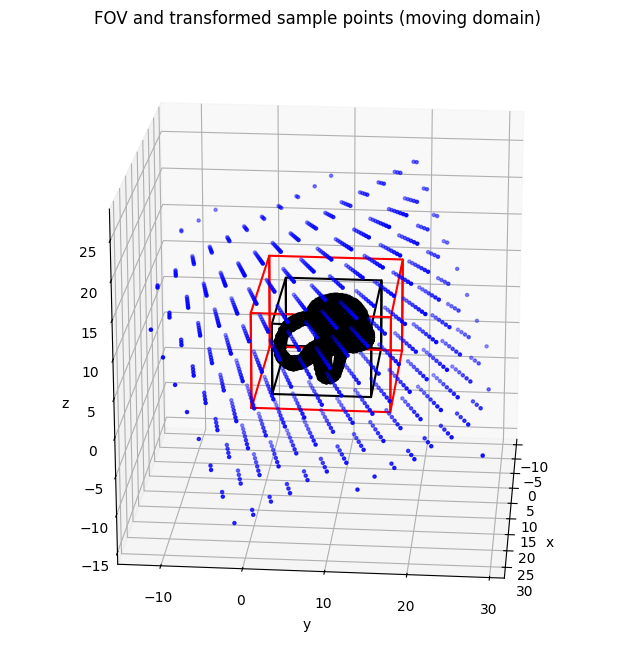

In [10]:
# Tranform and interpolate the new volume intensities

## --- Transform the query grid to the original space --- ##
# - Inverse rotation and then translate (add mean)
ptsQ_t = (ptsQ @ np.linalg.inv(rotation_matrix)) + points_mu

## ------------------------------------------------------ ##

# Evaluate transformed grid points in the moving image
fVal = F_moving(ptsQ_t)

# Reshape to voxel grid
volQ = np.reshape(fVal,newshape=qX.shape).astype('float16')

# Showcase the transformed query
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(ptsQ_t[::subset*5,0], ptsQ_t[::subset*5,1], ptsQ_t[::subset*5,2], c='b', marker='.')
plotFOVbox(ax, box, 'k')
plotFOVbox(ax, fov_pts, 'r')
ax.scatter(points[::subset,0], points[::subset,1], points[::subset,2], c='k', marker='.')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_aspect('equal')
ax.azim = viewPoint[0]
ax.elev = viewPoint[1]
ax.set_title('FOV and transformed sample points (moving domain)')

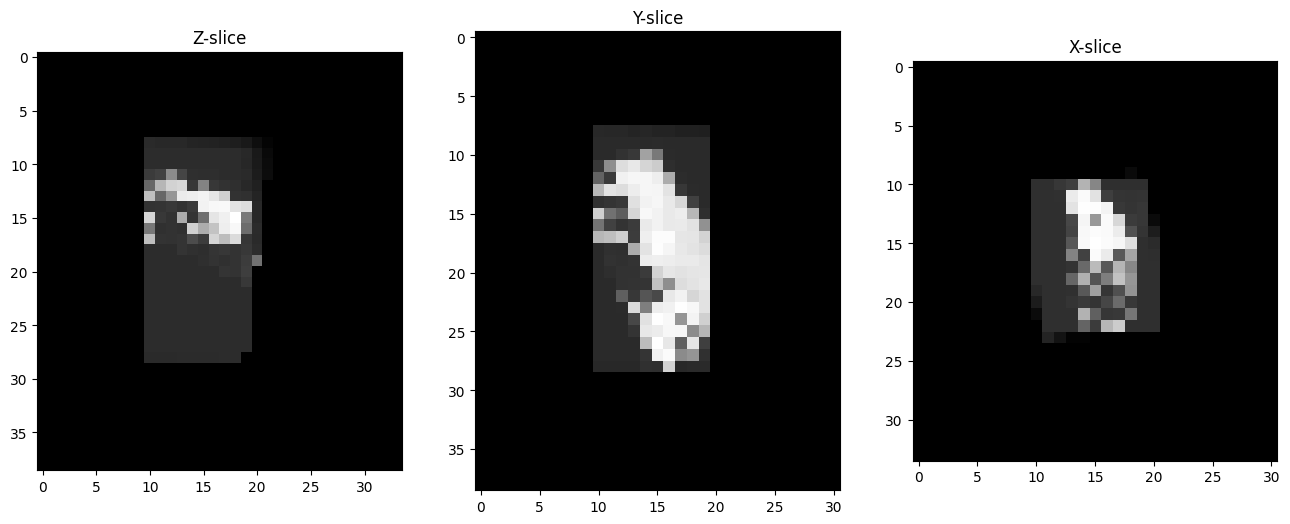

In [11]:
# Show slices from volQ

## --- Choose slices to display --- ##
sliceZ = 10
sliceY = 10
sliceX = 10

## -------------------------------- ##

fig, ax = plt.subplots(1,3, figsize=(16, 8))
ax[0].imshow(volQ[:,:,sliceZ], cmap='gray')
ax[0].set_title('Z-slice')
ax[1].imshow(volQ[:,sliceY,:], cmap='gray')
ax[1].set_title('Y-slice')
ax[2].imshow(volQ[sliceX,:,:], cmap='gray')
ax[2].set_title('X-slice')
plt.show()

In [13]:
## --- Where to store --- ##
outFolder = 'data'
outFile = 'pcani.nii'
## ---------------------- ##

# Prep minimal nifti (.nii) header
origin = np.array([xMin,yMin,zMin])
affineNew = np.zeros((4,4))
affineNew[0:3,3] = origin
affineNew[0,0] = spacing
affineNew[1,1] = spacing
affineNew[2,2] = spacing
volQ = volQ.astype(np.float32)
# Store
niiPCA = nib.Nifti1Image(volQ,affineNew)
nib.save(niiPCA,outFolder + outFile)

print('Volume exported')

Volume exported
